# 데이터 불러오기

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import copy
import os

In [2]:
# making "./data" directory
if os.path.isdir("./data"):
    pass
else: 
    os.mkdir("./data")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)

1.13.0+cu116
11.6


In [7]:
from torch_geometric.data import Data
import torch.nn.functional as F
from copy import deepcopy

In [8]:
from rdkit import Chem, RDLogger

In [9]:
from tqdm import tqdm

In [10]:
allowable_features = {
    'possible_atomic_num_list' : list(range(1, 119)) + ['misc'],
    'possible_bond_type_list' : [
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
        'misc'
    ],
}

In [11]:
def safe_index(l, e):
    """
    Return index of element e in list l. If e is not present, return the last index
    """
    try:
        return l.index(e)
    except:
        return len(l) - 1

def atom_to_feature_vector(atom):
    """
    Converts rdkit atom object to feature list of indices
    :param mol: rdkit atom object
    :return: list
    """
    atom_feature = [
            safe_index(allowable_features['possible_atomic_num_list'], atom.GetAtomicNum()),
            ]
    return atom_feature

def bond_to_feature_vector(bond):
    """
    Converts rdkit bond object to feature list of indices
    :param mol: rdkit bond object
    :return: list
    """
    bond_feature = [
                safe_index(allowable_features['possible_bond_type_list'], str(bond.GetBondType())),
            ]
    return bond_feature

def from_mol(mol_file, y=None, smiles=None):
    r"""Converts a Molecule data to a :class:`torch_geometric.data.Data` instance.

    Args:
        y(list, optional): target value
        mol_file (string, optional): The Mol filename string.
    """
    RDLogger.DisableLog('rdApp.*')
    
    if y is not None:
        y = torch.tensor(y, dtype=torch.float)
    mol = Chem.SDMolSupplier(mol_file, removeHs=False,
                                   sanitize=False)
    mol = mol[0]
    xs = []
    xc = []
    for i, atom in enumerate(mol.GetAtoms()):
        positions = mol.GetConformer().GetAtomPosition(i)
        x = atom_to_feature_vector(atom)
        xc.append([positions.x, positions.y, positions.z])
        xs.append(x)
    
    x = torch.tensor(xs, dtype=torch.float).view(-1, 1)  # Embedding 사용 시 dtype=torch.long
    xc = torch.tensor(xc, dtype=torch.float).view(-1, 3)
    
    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = bond_to_feature_vector(bond)

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float).view(-1, 1)  # Embedding 사용 시 dtype=torch.long

    if edge_index.numel() > 0:  # Sort indices.
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    return Data(x=x, pos=xc, y=y, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)

In [17]:
# 다시 한 번 불러옴..? index_col 추가됨
train = pd.read_csv('/content/drive/MyDrive/train.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/test.csv', index_col=0)

# 빈 list 생성
train_num_nodes_list = list()
test_num_nodes_list = list()
train_list = list()
test_list = list()


for idx in tqdm(train.index):
     d = torch.load(f"/content/drive/MyDrive/data_pt/data/train/{idx}.pt")
     train_list.append(d)
     train_num_nodes_list.append(d.num_nodes)

for idx in tqdm(test.index):
     d = torch.load(f"/content/drive/MyDrive/data_pt/data/test/{idx}.pt")
     test_list.append(d)
     test_num_nodes_list.append(d.num_nodes)

100%|██████████| 1217/1217 [00:02<00:00, 520.42it/s]


In [18]:
# 분자 번호 one hot encoding

for i in range(len(train_list)):
  train_list[i].x = F.one_hot(train_list[i].x.reshape(train_num_nodes_list[i]).long(),9)
  
for i in range(len(test_list)):
  test_list[i].x = F.one_hot(test_list[i].x.reshape(test_num_nodes_list[i]).long(),9).float()

In [80]:
# 데이터셋 섞기
import random

random.shuffle(train_list)
train_set = train_list[:9500]
valid_set = train_list[9500:]

In [81]:
#from torch_geometric.loader import DataLoader

In [82]:
from torch_geometric.loader import DataLoader

batch = 100
test_loader = DataLoader(test_list, batch_size = 1)
train_loader = DataLoader(train_set, batch_size = batch, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size = batch)

In [83]:
# 모델을 만들기 위해서, 이러한 GNN layer를 구현해보자 (최종 architecture에 사용할 layer의 구조를 디자인)
from torch_geometric.nn import MessagePassing
import torch.nn as nn
class MPNNLayer(MessagePassing):   
    #(MessagePassing): 알아서 aggregation하고 update해줌! 아래의 def 이름들 그대로 가져가야함
    def __init__(self, in_features, out_features):  # edge feature의 dimension를 활용하려면 뒤에 추가해야함
        super(MPNNLayer, self).__init__(aggr='add')
        
        # 여기가 파이 부분
        self.msg_func = nn.Sequential(*[
            nn.Linear(in_features, out_features),
            nn.ReLU()
        ])
        
        # 여기가 감마 부분
        self.update_func = nn.Sequential(*[
            nn.Linear(in_features + out_features, out_features),
            nn.ReLU()
        ])
        
    def forward(self, x, edge_index, edge_attr=None):
        # edge_index: 2 x E
        # edge_attr : E x edge_features(==1 for now)
        # x(node feature): V(노드수) x in_features(input으로 들어오는 feature vector의 dimension)
        # aggr_msg  : V x out_features(embedding vetor의 dimension)
        # x_update  : V x out_features
        
        # self.propagate : compute messages(step 1), followed by aggregation(step 2)
        aggr_msg = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        # self.update : update node features (step 3)
        x_update = self.update(aggr_msg, x)

        return x_update

    # ============== Step 1: Compute Messages ====================
    # 메시지를 어떻게 계산할지 정의, 
    def message(self, x_i, x_j, edge_attr):
        # x_i       : E x in_features
        # x_j       : E x in_features (j:보통 이웃한 노드의 인덱스를 나타내는 기호)
        # edge_attr : E x edge_features(==1 for now)
        # msg_ji    : E x out_features

        if edge_attr is None:
            argin = x_j - x_i     
        else:
            argin = 0.2*(edge_attr+1) * (x_j)  # edge attr [0 1 2] to edge attr [0.2 0.4 0.6]
            
        msg_ji = self.msg_func(argin)

        return msg_ji
    # ============== Step 2: Aggregate Messages (Implicit) ======
    
    # ============== Step 3: Update Node Features ===============
    def update(self, aggr_msg, x):
        return self.update_func(torch.cat((x, aggr_msg), dim=-1))

In [89]:
from torch_geometric.nn.glob import global_mean_pool

class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        #self.encode = nn.Linear(9,32)

        self.mpnn1 = MPNNLayer(9, 64)  
        self.mpnn2 = MPNNLayer(64, 64)  
        self.mpnn3 = MPNNLayer(64, 64)
        self.mpnn4 = MPNNLayer(64, 32)

        self.decode = nn.Linear(32,1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(32)
        

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = x.float()

        #x = self.encode(x)
        x = self.mpnn1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = self.mpnn2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = self.mpnn3(x, edge_index, edge_attr)
        x = self.bn3(x)
        x = self.mpnn4(x, edge_index, edge_attr)
        x = self.bn4(x)

        x = global_mean_pool(x, data.batch)
        x = F.dropout(x,0.5)
        x = self.decode(x)
        return x
        # return F.log_softmax(x, dim=0)

In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) # 최적화로 adam사용

# 모델학습

criterion = nn.MSELoss()
train_loss_his = []
valid_loss_his = []
best_loss = 10e10
for epoch in tqdm(range(400)):
  train_loss = 0
  valid_loss = 0
  model.train()
  for data in train_loader:
    data = data.to(device)
    optimizer.zero_grad()
        
    out = model(data)
    
    loss = criterion(input = out, target = data.y.reshape(data.batch.max()+1,1)) # mseloss
    loss.backward()
    optimizer.step()
    train_loss+= loss.item()
  model.eval()
  for data in valid_loader:
    data = data.to(device)
        
    out = model(data)
    
    loss = criterion(input = out, target = data.y.reshape(data.batch.max()+1,1)) # mseloss
      
    valid_loss+= loss.item()
  train_loss /= len(train_loader)
  valid_loss /= len(valid_loader)
  train_loss_his.append(train_loss)
  valid_loss_his.append(valid_loss)
  if valid_loss < best_loss: # validation loss 제일 낮은 모델
    best_model = deepcopy(model)
    best_loss = valid_loss
  print(epoch,train_loss,valid_loss)

  0%|          | 1/400 [00:01<09:18,  1.40s/it]

0 2.959039935312773 1.947940985361735


  0%|          | 2/400 [00:02<09:21,  1.41s/it]

1 1.8244395362703423 3.628516753514608


  1%|          | 3/400 [00:04<09:18,  1.41s/it]

2 1.7546265451531662 1.5380715529123943


  1%|          | 4/400 [00:05<09:14,  1.40s/it]

3 1.6081455375018874 1.456136671702067


  1%|▏         | 5/400 [00:06<09:07,  1.39s/it]

4 1.5381312759299026 1.4387923200925192


  2%|▏         | 6/400 [00:08<09:02,  1.38s/it]

5 1.5261818829335665 1.5033907016118369


  2%|▏         | 7/400 [00:09<09:00,  1.37s/it]

6 1.5001779129630641 1.9989841063817342


  2%|▏         | 8/400 [00:11<08:58,  1.37s/it]

7 1.479927813379388 1.4205491264661154


  2%|▏         | 9/400 [00:12<08:57,  1.37s/it]

8 1.4169557822378058 1.5224420070648192


  2%|▎         | 10/400 [00:13<08:57,  1.38s/it]

9 1.3832778610681233 1.5919774452845254


  3%|▎         | 11/400 [00:15<08:54,  1.37s/it]

10 1.4018636552911057 1.5288523197174073


  3%|▎         | 12/400 [00:16<08:54,  1.38s/it]

11 1.4226472591098986 1.3505699276924132


  3%|▎         | 13/400 [00:18<09:00,  1.40s/it]

12 1.3662547086414538 1.3895045042037963


  4%|▎         | 14/400 [00:19<08:57,  1.39s/it]

13 1.3508795631559272 2.3167927742004393


  4%|▍         | 15/400 [00:20<08:55,  1.39s/it]

14 1.3445079621515776 1.2150859673817953


  4%|▍         | 16/400 [00:22<08:54,  1.39s/it]

15 1.3104161149577092 1.2534828225771586


  4%|▍         | 17/400 [00:23<08:52,  1.39s/it]

16 1.2852455823045028 1.399986445903778


  4%|▍         | 18/400 [00:25<08:56,  1.40s/it]

17 1.283891014676345 1.3703553318977355


  5%|▍         | 19/400 [00:26<08:47,  1.39s/it]

18 1.2832175982625862 2.080714797973633


  5%|▌         | 20/400 [00:27<08:44,  1.38s/it]

19 1.2711782066445603 1.8837648948033652


  5%|▌         | 21/400 [00:29<08:39,  1.37s/it]

20 1.327269845259817 1.6193791071573893


  6%|▌         | 22/400 [00:30<08:39,  1.37s/it]

21 1.2433699783525969 1.4948772350947062


  6%|▌         | 23/400 [00:31<08:35,  1.37s/it]

22 1.2521481156349181 1.362656839688619


  6%|▌         | 24/400 [00:33<08:37,  1.38s/it]

23 1.2318385619866221 8.599305725097656


  6%|▋         | 25/400 [00:34<08:32,  1.37s/it]

24 1.2045916871020668 2.2045276800791425


  6%|▋         | 26/400 [00:35<08:29,  1.36s/it]

25 1.250006774224733 1.1200063586235047


  7%|▋         | 27/400 [00:37<08:27,  1.36s/it]

26 1.1674683250878986 1.986412517229716


  7%|▋         | 28/400 [00:38<08:25,  1.36s/it]

27 1.2350539508618807 2.292609628041585


  7%|▋         | 29/400 [00:39<08:22,  1.36s/it]

28 1.2314058090511122 25.568603388468425


  8%|▊         | 30/400 [00:41<08:22,  1.36s/it]

29 1.1921171608724093 1.1949374119440714


  8%|▊         | 31/400 [00:42<08:19,  1.35s/it]

30 1.1298177028957166 1.5093846797943116


  8%|▊         | 32/400 [00:44<08:21,  1.36s/it]

31 1.254661338580282 1.847225030263265


  8%|▊         | 33/400 [00:45<08:18,  1.36s/it]

32 1.2365116947575618 1.8618598461151123


  8%|▊         | 34/400 [00:46<08:15,  1.35s/it]

33 1.1665702148487693 1.4841325998306274


  9%|▉         | 35/400 [00:48<08:22,  1.38s/it]

34 1.1462041792116666 2.751227879524231


  9%|▉         | 36/400 [00:49<08:20,  1.38s/it]

35 1.1376236739911532 1.3843568086624145


  9%|▉         | 37/400 [00:50<08:20,  1.38s/it]

36 1.1290135778878865 1.0843312899271647


 10%|▉         | 38/400 [00:52<08:20,  1.38s/it]

37 1.105667471258264 2.222058971722921


 10%|▉         | 39/400 [00:53<08:15,  1.37s/it]

38 1.132573858687752 3.9671829462051393


 10%|█         | 40/400 [00:55<08:15,  1.38s/it]

39 1.2963354719312568 1.4057076255480447


 10%|█         | 41/400 [00:56<08:13,  1.37s/it]

40 1.274280025457081 1.948813756306966


 10%|█         | 42/400 [00:57<08:10,  1.37s/it]

41 1.2881667758289137 8.610390090942383


 11%|█         | 43/400 [00:59<08:08,  1.37s/it]

42 1.2843869265757109 1.452516504128774


 11%|█         | 44/400 [01:00<08:04,  1.36s/it]

43 1.1615414763751784 1.2258833130200704


 11%|█▏        | 45/400 [01:01<08:03,  1.36s/it]

44 1.1579966896458675 1.2656771779060363


 12%|█▏        | 46/400 [01:03<08:03,  1.36s/it]

45 1.1240977710799167 1.014355222384135


 12%|█▏        | 47/400 [01:04<08:01,  1.36s/it]

46 1.086677076314625 1.4039375106493632


 12%|█▏        | 48/400 [01:05<08:00,  1.37s/it]

47 1.100678100711421 1.2413934151331583


 12%|█▏        | 49/400 [01:07<07:56,  1.36s/it]

48 1.032692948140596 1.9174959778785705


 12%|█▎        | 50/400 [01:08<07:53,  1.35s/it]

49 1.08021727863111 1.0336340030034383


 13%|█▎        | 51/400 [01:09<07:51,  1.35s/it]

50 1.0356287780560944 1.1084485133488973


 13%|█▎        | 52/400 [01:11<07:50,  1.35s/it]

51 1.0616149212184705 1.7531904538472494


 13%|█▎        | 53/400 [01:12<07:49,  1.35s/it]

52 1.1153878764102334 1.0752479314804078


 14%|█▎        | 54/400 [01:14<07:51,  1.36s/it]

53 1.1159011464369923 1.997977368036906


 14%|█▍        | 55/400 [01:15<07:51,  1.37s/it]

54 1.079689988337065 1.019845732053121


 14%|█▍        | 56/400 [01:16<07:52,  1.37s/it]

55 1.013982860038155 1.4021752953529358


 14%|█▍        | 57/400 [01:18<07:53,  1.38s/it]

56 1.0551158836013392 0.9728506763776144


 14%|█▍        | 58/400 [01:19<07:49,  1.37s/it]

57 1.040911971267901 1.66031924088796


 15%|█▍        | 59/400 [01:20<07:48,  1.37s/it]

58 1.0197449897464952 1.1794410347938538


 15%|█▌        | 60/400 [01:22<07:46,  1.37s/it]

59 1.0093006501072332 0.9949073354403178


 15%|█▌        | 61/400 [01:23<07:43,  1.37s/it]

60 0.9941261617760909 1.42781666914622


 16%|█▌        | 62/400 [01:25<07:43,  1.37s/it]

61 1.0233830596271314 1.589886983235677


 16%|█▌        | 63/400 [01:26<07:42,  1.37s/it]

62 1.023997740369094 2.0930775086085003


 16%|█▌        | 64/400 [01:27<07:41,  1.37s/it]

63 1.0098743463817397 1.6412915468215943


 16%|█▋        | 65/400 [01:29<07:39,  1.37s/it]

64 1.0277214520855953 1.0047502358754477


 16%|█▋        | 66/400 [01:30<07:36,  1.37s/it]

65 1.0058253332188254 1.0570424556732179


 17%|█▋        | 67/400 [01:31<07:32,  1.36s/it]

66 1.0024665380779065 0.982657519976298


 17%|█▋        | 68/400 [01:33<07:33,  1.37s/it]

67 1.0038625491292854 1.0638127446174621


 17%|█▋        | 69/400 [01:34<07:31,  1.36s/it]

68 0.9945006276431837 1.5031075080235798


 18%|█▊        | 70/400 [01:35<07:27,  1.36s/it]

69 1.0360968232154846 1.3521024902661642


 18%|█▊        | 71/400 [01:37<07:27,  1.36s/it]

70 1.0452742244067945 1.2828391194343567


 18%|█▊        | 72/400 [01:38<07:28,  1.37s/it]

71 0.9707617828720494 1.079913040002187


 18%|█▊        | 73/400 [01:40<07:27,  1.37s/it]

72 1.0079259182277478 1.2724857449531555


 18%|█▊        | 74/400 [01:41<07:26,  1.37s/it]

73 0.9760206705645511 1.4814570824305215


 19%|█▉        | 75/400 [01:42<07:24,  1.37s/it]

74 0.9900982737541199 1.1732774019241332


 19%|█▉        | 76/400 [01:44<07:20,  1.36s/it]

75 0.9958661932694285 0.9313613573710123


 19%|█▉        | 77/400 [01:45<07:19,  1.36s/it]

76 0.9810568025237636 1.1295589963595072


 20%|█▉        | 78/400 [01:46<07:16,  1.36s/it]

77 0.9825500732974002 1.2543078025182088


 20%|█▉        | 79/400 [01:48<07:21,  1.37s/it]

78 0.9827255888989097 2.182099183400472


 20%|██        | 80/400 [01:49<07:24,  1.39s/it]

79 0.9878298383010061 1.023716640472412


 20%|██        | 81/400 [01:51<07:22,  1.39s/it]

80 0.9709500959045009 1.3891113996505737


 20%|██        | 82/400 [01:52<07:18,  1.38s/it]

81 1.026520257874539 1.085911254088084


 21%|██        | 83/400 [01:53<07:15,  1.38s/it]

82 1.0563208649032994 0.9309246460596721


 21%|██        | 84/400 [01:55<07:13,  1.37s/it]

83 0.9813749658434014 1.0126686255137125


 21%|██▏       | 85/400 [01:56<07:11,  1.37s/it]

84 1.0174527249838177 1.1469151775042217


 22%|██▏       | 86/400 [01:57<07:10,  1.37s/it]

85 0.996563499538522 1.3995718081792197


 22%|██▏       | 87/400 [01:59<07:13,  1.38s/it]

86 0.9636048511454933 1.2427228530248007


 22%|██▏       | 88/400 [02:00<07:10,  1.38s/it]

87 0.9759121405450921 0.9535765250523885


 22%|██▏       | 89/400 [02:02<07:09,  1.38s/it]

88 0.9460701465606689 1.5669601241747537


 22%|██▎       | 90/400 [02:03<07:07,  1.38s/it]

89 0.9997545656404997 2.0413057883580525


 23%|██▎       | 91/400 [02:04<07:07,  1.38s/it]

90 0.9612650789712605 0.9149882316589355


 23%|██▎       | 92/400 [02:06<07:03,  1.38s/it]

91 0.9403452615988882 1.303914455572764


 23%|██▎       | 93/400 [02:07<07:01,  1.37s/it]

92 1.0008042454719543 0.9895251274108887


 24%|██▎       | 94/400 [02:08<07:00,  1.37s/it]

93 0.9452043916049756 3.8881980895996096


 24%|██▍       | 95/400 [02:10<06:56,  1.37s/it]

94 0.9849613302632382 1.9552384614944458


 24%|██▍       | 96/400 [02:11<06:54,  1.36s/it]

95 1.0156139442795202 1.8646526018778482


 24%|██▍       | 97/400 [02:13<06:55,  1.37s/it]

96 0.9730566727487664 1.0313339948654174


 24%|██▍       | 98/400 [02:14<06:52,  1.37s/it]

97 0.987697812757994 1.5237689018249512


 25%|██▍       | 99/400 [02:15<06:50,  1.36s/it]

98 0.9691120103785866 1.1340878446896872


 25%|██▌       | 100/400 [02:17<06:47,  1.36s/it]

99 0.9421131397548475 1.6229629913965862


 25%|██▌       | 101/400 [02:18<06:49,  1.37s/it]

100 0.9539261786561263 1.027906882762909


 26%|██▌       | 102/400 [02:19<06:51,  1.38s/it]

101 0.9210364777790873 0.9021760741869609


 26%|██▌       | 103/400 [02:21<06:49,  1.38s/it]

102 0.9933042965437237 1.1598776976267497


 26%|██▌       | 104/400 [02:22<06:44,  1.37s/it]

103 0.9725906635585584 126.05972239176432


 26%|██▋       | 105/400 [02:24<06:42,  1.37s/it]

104 0.9833900727723774 1.4613651514053345


 26%|██▋       | 106/400 [02:25<06:42,  1.37s/it]

105 1.002838917155015 1.9137678066889445


 27%|██▋       | 107/400 [02:26<06:40,  1.37s/it]

106 0.9786693535353008 0.9156379103660583


 27%|██▋       | 108/400 [02:28<06:40,  1.37s/it]

107 0.9249908798619321 1.1956876039505004


 27%|██▋       | 109/400 [02:29<06:38,  1.37s/it]

108 0.9173128219027268 2.2762153784434003


 28%|██▊       | 110/400 [02:30<06:40,  1.38s/it]

109 0.9413513779640198 1.0061129570007323


 28%|██▊       | 111/400 [02:32<06:37,  1.37s/it]

110 0.9248065694382316 1.2192925175031026


 28%|██▊       | 112/400 [02:33<06:34,  1.37s/it]

111 0.9588736935665733 1.7820716142654418


 28%|██▊       | 113/400 [02:35<06:35,  1.38s/it]

112 0.9171513607627467 0.9770114660263062


 28%|██▊       | 114/400 [02:36<06:33,  1.38s/it]

113 0.9564054834215264 0.9442332704861959


 29%|██▉       | 115/400 [02:37<06:31,  1.37s/it]

114 0.9296592047339991 1.1398523132006326


 29%|██▉       | 116/400 [02:39<06:29,  1.37s/it]

115 0.9247030484048944 1.339062221844991


 29%|██▉       | 117/400 [02:40<06:29,  1.38s/it]

116 0.9318269999403702 0.9581151922543844


 30%|██▉       | 118/400 [02:41<06:28,  1.38s/it]

117 0.9474934235999458 3.1994106769561768


 30%|██▉       | 119/400 [02:43<06:28,  1.38s/it]

118 0.9459963858127594 1.203286317984263


 30%|███       | 120/400 [02:44<06:28,  1.39s/it]

119 0.9552003628329226 1.259098502000173


 30%|███       | 121/400 [02:46<06:28,  1.39s/it]

120 0.9614624719870718 2.128097995122274


 30%|███       | 122/400 [02:47<06:24,  1.38s/it]

121 0.9479788083779185 1.25989720026652


 31%|███       | 123/400 [02:48<06:22,  1.38s/it]

122 0.9538397305890134 1.076130708058675


 31%|███       | 124/400 [02:50<06:24,  1.39s/it]

123 0.9587640875264218 1.24899476369222


 31%|███▏      | 125/400 [02:51<06:27,  1.41s/it]

124 0.920049386275442 6.259849770863851


 32%|███▏      | 126/400 [02:53<06:25,  1.41s/it]

125 0.9791315649685107 1.4072786211967467


 32%|███▏      | 127/400 [02:54<06:22,  1.40s/it]

126 0.9131809912229839 0.9951601425806681


 32%|███▏      | 128/400 [02:55<06:22,  1.41s/it]

127 0.9323986605594032 0.9300421277681986


 32%|███▏      | 129/400 [02:57<06:19,  1.40s/it]

128 0.9257190218097285 1.0840622584025066


 32%|███▎      | 130/400 [02:58<06:16,  1.39s/it]

129 0.9158664295547887 0.9503396073977153


 33%|███▎      | 131/400 [03:00<06:15,  1.39s/it]

130 0.9400685304089597 0.9351630091667176


 33%|███▎      | 132/400 [03:01<06:12,  1.39s/it]

131 0.9497526959369057 1.2718654870986938


 33%|███▎      | 133/400 [03:02<06:11,  1.39s/it]

132 1.0374964481905886 1.1702619314193725


 34%|███▎      | 134/400 [03:04<06:10,  1.39s/it]

133 0.9697321264367355 1.177068813641866


 34%|███▍      | 135/400 [03:05<06:04,  1.38s/it]

134 0.9341304201828806 1.3959710041681925


 34%|███▍      | 136/400 [03:06<06:01,  1.37s/it]

135 0.9308847119933681 1.3071732997894288


 34%|███▍      | 137/400 [03:08<06:02,  1.38s/it]

136 0.8994056858514484 3.9157345930735272


 34%|███▍      | 138/400 [03:09<05:59,  1.37s/it]

137 0.9291306665069179 0.902280588944753


 35%|███▍      | 139/400 [03:11<05:56,  1.37s/it]

138 0.929989038643084 0.9569152196248373


 35%|███▌      | 140/400 [03:12<05:56,  1.37s/it]

139 0.8843358027307611 0.9558918793996175


 35%|███▌      | 141/400 [03:13<05:55,  1.37s/it]

140 0.9562148665127002 1.805326279004415


 36%|███▌      | 142/400 [03:15<05:51,  1.36s/it]

141 0.9396959982420269 0.9148420731226603


 36%|███▌      | 143/400 [03:16<06:25,  1.50s/it]

142 0.8972349631158929 1.0323224186897277


 36%|███▌      | 144/400 [03:18<06:59,  1.64s/it]

143 0.9273325229945936 0.9574657162030538


 36%|███▋      | 145/400 [03:20<07:00,  1.65s/it]

144 0.943368831433748 0.9605570713678996


 36%|███▋      | 146/400 [03:21<06:40,  1.58s/it]

145 0.9098792967043425 1.2680886467297872


 37%|███▋      | 147/400 [03:23<06:23,  1.52s/it]

146 0.9195339002107319 3.5299227555592854


 37%|███▋      | 148/400 [03:24<06:11,  1.47s/it]

147 0.9635787838383725 1.5494382937749227


 37%|███▋      | 149/400 [03:26<06:01,  1.44s/it]

148 0.9346717627424943 1.0198664903640746


 38%|███▊      | 150/400 [03:27<05:53,  1.41s/it]

149 0.9038696602771157 0.9186753273010254


 38%|███▊      | 151/400 [03:28<05:50,  1.41s/it]

150 0.8867993671643106 1.0218808968861899


 38%|███▊      | 152/400 [03:30<05:46,  1.40s/it]

151 0.910952867959675 1.0395649234453836


 38%|███▊      | 153/400 [03:31<05:43,  1.39s/it]

152 0.904793109391865 1.0026891390482584


 38%|███▊      | 154/400 [03:32<05:38,  1.38s/it]

153 0.8951922780589053 1.5203016678492227


 39%|███▉      | 155/400 [03:34<05:38,  1.38s/it]

154 0.8871370045762313 1.2209923028945924


 39%|███▉      | 156/400 [03:35<05:35,  1.37s/it]

155 0.9054553013098867 1.0413352012634278


 39%|███▉      | 157/400 [03:37<05:32,  1.37s/it]

156 0.9165669039676064 0.8824855327606201


 40%|███▉      | 158/400 [03:38<05:29,  1.36s/it]

157 0.9321637335576509 0.9101523637771607


 40%|███▉      | 159/400 [03:39<05:28,  1.36s/it]

158 0.8823743067289653 0.9841352502504984


 40%|████      | 160/400 [03:41<05:28,  1.37s/it]

159 0.9038073420524597 1.0603100697199503


 40%|████      | 161/400 [03:42<05:26,  1.37s/it]

160 0.8927366385334417 1.1469497164090474


 40%|████      | 162/400 [03:43<05:28,  1.38s/it]

161 0.9104395947958294 0.9289396524429321


 41%|████      | 163/400 [03:45<05:25,  1.37s/it]

162 0.9196430356878983 1.3206936279932657


 41%|████      | 164/400 [03:46<05:24,  1.38s/it]

163 0.9188676140810313 0.9191659768422444


 41%|████▏     | 165/400 [03:47<05:21,  1.37s/it]

164 0.9380553091827192 1.1600883801778157


 42%|████▏     | 166/400 [03:49<05:20,  1.37s/it]

165 0.9031279877612465 0.9953451911608379


 42%|████▏     | 167/400 [03:50<05:23,  1.39s/it]

166 0.8982459626699749 0.9672378579775492


 42%|████▏     | 168/400 [03:52<05:22,  1.39s/it]

167 0.8851340670334665 1.1307175477345786


 42%|████▏     | 169/400 [03:53<05:19,  1.38s/it]

168 0.9338317262498956 0.9628663619359334


 42%|████▎     | 170/400 [03:54<05:16,  1.37s/it]

169 0.9020896014414336 0.9346467932065328


 43%|████▎     | 171/400 [03:56<05:13,  1.37s/it]

170 0.8670815787817302 1.3473596453666687


 43%|████▎     | 172/400 [03:57<05:14,  1.38s/it]

171 0.8997544313731947 1.1156587918599448


 43%|████▎     | 173/400 [03:59<05:14,  1.38s/it]

172 1.0068215542717984 1.3262149135271708


 44%|████▎     | 174/400 [04:00<05:15,  1.40s/it]

173 0.9183067673131039 1.2643848458925884


 44%|████▍     | 175/400 [04:01<05:13,  1.39s/it]

174 0.9043554127216339 0.9778833985328674


 44%|████▍     | 176/400 [04:03<05:13,  1.40s/it]

175 0.896813976764679 1.1996375719706218


 44%|████▍     | 177/400 [04:04<05:13,  1.41s/it]

176 0.8835411761936388 0.9096302668253581


 44%|████▍     | 178/400 [04:06<05:12,  1.41s/it]

177 0.8835620491128219 2.745780571301778


 45%|████▍     | 179/400 [04:07<05:09,  1.40s/it]

178 0.8845012062474301 0.8602883418401083


 45%|████▌     | 180/400 [04:08<05:05,  1.39s/it]

179 0.8902533236302828 0.9053802371025086


 45%|████▌     | 181/400 [04:10<05:04,  1.39s/it]

180 0.8899729571844402 1.163740595181783


 46%|████▌     | 182/400 [04:11<05:03,  1.39s/it]

181 0.9817177333329853 1.2349737763404847


 46%|████▌     | 183/400 [04:13<05:01,  1.39s/it]

182 0.9121209081850554 0.9509906689325969


 46%|████▌     | 184/400 [04:14<05:00,  1.39s/it]

183 0.8993208276598077 0.9416237314542134


 46%|████▋     | 185/400 [04:15<05:00,  1.40s/it]

184 0.8722845613956451 1.0827926754951478


 46%|████▋     | 186/400 [04:17<04:57,  1.39s/it]

185 0.8802107073758778 0.96379101673762


 47%|████▋     | 187/400 [04:18<04:53,  1.38s/it]

186 0.8750172539761192 1.2696736375490825


 47%|████▋     | 188/400 [04:19<04:51,  1.38s/it]

187 0.9019491440371463 0.8571734150250753


 47%|████▋     | 189/400 [04:21<04:54,  1.40s/it]

188 0.9272472337672585 1.5190220634142557


 48%|████▊     | 190/400 [04:22<04:52,  1.39s/it]

189 0.9088890587028704 0.9841900149981181


 48%|████▊     | 191/400 [04:24<04:48,  1.38s/it]

190 0.9224934370894181 0.9431131720542908


 48%|████▊     | 192/400 [04:25<04:47,  1.38s/it]

191 0.8572211365950735 0.8268193920453389


 48%|████▊     | 193/400 [04:26<04:48,  1.40s/it]

192 0.8884363350115324 1.017374539375305


 48%|████▊     | 194/400 [04:28<04:47,  1.40s/it]

193 0.9687099180723492 0.9281047066052754


 49%|████▉     | 195/400 [04:30<05:21,  1.57s/it]

194 0.932170087412784 1.1234373887379965


 49%|████▉     | 196/400 [04:33<06:50,  2.01s/it]

195 0.9014197838933844 0.9543993711471558


 49%|████▉     | 197/400 [04:35<06:57,  2.06s/it]

196 0.9169988205558375 0.896833578745524


 50%|████▉     | 198/400 [04:37<06:47,  2.02s/it]

197 0.8637045866564701 0.9982080141703288


 50%|████▉     | 199/400 [04:38<06:07,  1.83s/it]

198 0.9191397328125803 1.0321422219276428


 50%|█████     | 200/400 [04:40<05:38,  1.69s/it]

199 0.8555350974986428 1.0610986709594727


 50%|█████     | 201/400 [04:41<05:17,  1.59s/it]

200 0.9089013576507569 0.9864839990933736


 50%|█████     | 202/400 [04:42<05:01,  1.52s/it]

201 0.8915979046570627 0.9507924795150757


 51%|█████     | 203/400 [04:44<04:50,  1.47s/it]

202 0.8894130029176411 0.9573850393295288


 51%|█████     | 204/400 [04:45<04:41,  1.44s/it]

203 0.8810925835057308 0.9266018231709798


 51%|█████▏    | 205/400 [04:46<04:34,  1.41s/it]

204 0.8744196590624358 1.0007006684939066


 52%|█████▏    | 206/400 [04:48<04:33,  1.41s/it]

205 0.8525314076950675 0.9340852061907451


 52%|█████▏    | 207/400 [04:49<04:31,  1.41s/it]

206 0.8826962721975227 2.467717170715332


 52%|█████▏    | 208/400 [04:51<04:30,  1.41s/it]

207 0.95487674286491 1.0904275258382161


 52%|█████▏    | 209/400 [04:52<04:27,  1.40s/it]

208 0.9142274034650703 0.9275314966837566


 52%|█████▎    | 210/400 [04:53<04:24,  1.39s/it]

209 0.9319172978401185 0.9329602162043253


 53%|█████▎    | 211/400 [04:55<04:30,  1.43s/it]

210 0.8764606334661182 0.9141963243484497


 53%|█████▎    | 212/400 [04:57<05:01,  1.60s/it]

211 0.8932806272255747 1.0199688394864401


 53%|█████▎    | 213/400 [04:59<05:22,  1.73s/it]

212 0.9056024331795541 1.2215595602989198


 54%|█████▎    | 214/400 [05:01<05:32,  1.79s/it]

213 0.884576754193557 1.0509082118670146


 54%|█████▍    | 215/400 [05:03<05:26,  1.77s/it]

214 0.8633543654492027 1.0799981276194255


 54%|█████▍    | 216/400 [05:04<05:03,  1.65s/it]

215 0.8692345336863869 0.9964138110478719


 54%|█████▍    | 217/400 [05:05<04:48,  1.58s/it]

216 0.8971542458785208 1.0220046798388163


 55%|█████▍    | 218/400 [05:07<04:34,  1.51s/it]

217 0.8543453724760758 1.074426249663035


 55%|█████▍    | 219/400 [05:08<04:25,  1.47s/it]

218 0.8736972024566249 0.8846533258756002


 55%|█████▌    | 220/400 [05:10<04:19,  1.44s/it]

219 0.8803822137807545 1.0224701484044394


 55%|█████▌    | 221/400 [05:11<04:15,  1.43s/it]

220 0.8980679693974947 1.059766137599945


 56%|█████▌    | 222/400 [05:12<04:13,  1.43s/it]

221 0.8950428391757764 0.9949378728866577


 56%|█████▌    | 223/400 [05:14<04:11,  1.42s/it]

222 0.9021584692754243 0.9164461096127828


 56%|█████▌    | 224/400 [05:15<04:08,  1.41s/it]

223 0.9197056193100779 0.9251899719238281


 56%|█████▋    | 225/400 [05:17<04:07,  1.41s/it]

224 0.8651076141156648 0.9549118518829346


 56%|█████▋    | 226/400 [05:18<04:05,  1.41s/it]

225 0.8851670484793813 0.9074752966562907


 57%|█████▋    | 227/400 [05:19<04:04,  1.41s/it]

226 0.8437723040580749 0.8839301983515422


 57%|█████▋    | 228/400 [05:21<04:05,  1.43s/it]

227 0.8854344713060479 1.0393886645634969


 57%|█████▋    | 229/400 [05:22<04:03,  1.42s/it]

228 0.8805650918107284 0.9485307415326436


 57%|█████▊    | 230/400 [05:24<04:01,  1.42s/it]

229 0.8878806468687559 0.9182562311490376


 58%|█████▊    | 231/400 [05:25<04:00,  1.42s/it]

230 0.8807974727530229 1.2104397813479106


 58%|█████▊    | 232/400 [05:27<03:59,  1.43s/it]

231 0.8967931728614004 1.424400305747986


 58%|█████▊    | 233/400 [05:28<03:57,  1.42s/it]

232 0.8645102996575205 1.0008734544118245


 58%|█████▊    | 234/400 [05:29<03:58,  1.44s/it]

233 0.8537252482615019 0.9505301157633463


 59%|█████▉    | 235/400 [05:31<03:55,  1.43s/it]

234 0.8955265396519712 1.1697776079177857


 59%|█████▉    | 236/400 [05:32<03:54,  1.43s/it]

235 0.9027199359316574 1.1210434794425965


 59%|█████▉    | 237/400 [05:34<03:50,  1.42s/it]

236 0.8930319259041234 1.1825048089027406


 60%|█████▉    | 238/400 [05:35<03:51,  1.43s/it]

237 0.9331010799658926 1.0968196153640748


 60%|█████▉    | 239/400 [05:36<03:47,  1.42s/it]

238 0.8957342781518635 1.180796253681183


 60%|██████    | 240/400 [05:38<03:46,  1.42s/it]

239 0.863043463230133 0.8957523266474406


 60%|██████    | 241/400 [05:39<03:44,  1.41s/it]

240 0.887351940180126 1.2848892132441203


 60%|██████    | 242/400 [05:41<03:43,  1.42s/it]

241 0.8786040544509888 1.0290120005607606


 61%|██████    | 243/400 [05:42<03:41,  1.41s/it]

242 0.9045307228439733 1.1627448240915934


 61%|██████    | 244/400 [05:44<03:41,  1.42s/it]

243 0.8899812086632377 1.086678922176361


 61%|██████▏   | 245/400 [05:45<03:39,  1.41s/it]

244 0.887654657740342 0.870217231909434


 62%|██████▏   | 246/400 [05:46<03:37,  1.41s/it]

245 0.8834513018005773 1.3829048554102579


 62%|██████▏   | 247/400 [05:48<03:35,  1.41s/it]

246 0.8563572036592584 1.0141624172528585


 62%|██████▏   | 248/400 [05:49<03:34,  1.41s/it]

247 0.8943803100209488 1.292987843354543


 62%|██████▏   | 249/400 [05:51<03:32,  1.41s/it]

248 0.9370608643481606 1.1014578978220622


 62%|██████▎   | 250/400 [05:52<03:30,  1.40s/it]

249 0.9340556452148839 1.1944305062294007


 63%|██████▎   | 251/400 [05:53<03:27,  1.40s/it]

250 0.8831109790425552 1.0471426844596863


 63%|██████▎   | 252/400 [05:55<03:27,  1.40s/it]

251 0.9019570890225862 0.9305434862772624


 63%|██████▎   | 253/400 [05:56<03:25,  1.40s/it]

252 0.8828270209463019 0.9475716551144918


 64%|██████▎   | 254/400 [05:58<03:23,  1.39s/it]

253 0.862639476123609 0.8616833249727885


 64%|██████▍   | 255/400 [05:59<03:20,  1.38s/it]

254 0.8507325994340997 0.8798528194427491


 64%|██████▍   | 256/400 [06:00<03:20,  1.39s/it]

255 0.8529256506970054 1.6018134832382203


 64%|██████▍   | 257/400 [06:02<03:18,  1.39s/it]

256 0.8666160771721287 0.9788191517194113


 64%|██████▍   | 258/400 [06:03<03:16,  1.38s/it]

257 0.8844235056325009 0.9493718226750691


 65%|██████▍   | 259/400 [06:04<03:14,  1.38s/it]

258 0.8757691863336061 2.0764392614364624


 65%|██████▌   | 260/400 [06:06<03:13,  1.38s/it]

259 0.8621261163761741 1.0587355732917785


 65%|██████▌   | 261/400 [06:07<03:10,  1.37s/it]

260 0.9201588793804771 1.1806881388028463


 66%|██████▌   | 262/400 [06:09<03:09,  1.37s/it]

261 0.9043691785711991 0.8743081490198771


 66%|██████▌   | 263/400 [06:10<03:07,  1.37s/it]

262 0.878826599999478 1.1138338446617126


 66%|██████▌   | 264/400 [06:11<03:05,  1.37s/it]

263 0.8989364900087056 1.081367282072703


 66%|██████▋   | 265/400 [06:13<03:06,  1.38s/it]

264 0.8990158802584598 0.9398111224174499


 66%|██████▋   | 266/400 [06:14<03:04,  1.38s/it]

265 0.914230844221617 0.9501647194226582


 67%|██████▋   | 267/400 [06:15<03:02,  1.37s/it]

266 0.8706651355090894 1.340220332145691


 67%|██████▋   | 268/400 [06:17<03:01,  1.37s/it]

267 0.8607697725296021 0.943849507967631


 67%|██████▋   | 269/400 [06:18<03:09,  1.44s/it]

268 0.8812804818153381 1.0233529170354208


 68%|██████▊   | 270/400 [06:20<03:09,  1.46s/it]

269 0.8749318380104868 1.0139357964197795


 68%|██████▊   | 271/400 [06:21<03:05,  1.43s/it]

270 0.8805597948400598 0.8913283864657084


 68%|██████▊   | 272/400 [06:23<03:01,  1.41s/it]

271 0.8509082838108665 1.0943073829015095


 68%|██████▊   | 273/400 [06:24<02:57,  1.40s/it]

272 0.9255922662584405 0.9573527256647746


 68%|██████▊   | 274/400 [06:25<02:56,  1.40s/it]

273 0.9014681747085169 1.0324204206466674


 69%|██████▉   | 275/400 [06:27<02:53,  1.39s/it]

274 0.8582732790394834 1.3066215356191


 69%|██████▉   | 276/400 [06:28<02:51,  1.38s/it]

275 0.8700222391831247 1.025394070148468


 69%|██████▉   | 277/400 [06:30<02:49,  1.38s/it]

276 0.9129527361769425 1.6230985879898072


 70%|██████▉   | 278/400 [06:31<02:47,  1.37s/it]

277 0.8808566394605135 0.9545135021209716


 70%|██████▉   | 279/400 [06:32<02:46,  1.37s/it]

278 0.8649966986555803 1.5419079860051472


 70%|███████   | 280/400 [06:34<02:44,  1.37s/it]

279 0.8807839117552104 1.469777274131775


 70%|███████   | 281/400 [06:35<02:44,  1.38s/it]

280 0.8769190349076924 1.8322214484214783


 70%|███████   | 282/400 [06:37<03:16,  1.67s/it]

281 0.8966707543322915 0.8819340268770853


 71%|███████   | 283/400 [06:39<03:05,  1.59s/it]

282 0.9307595359651666 0.9956979076067607


 71%|███████   | 284/400 [06:40<02:57,  1.53s/it]

283 0.8896032189068042 1.1362112283706665


 71%|███████▏  | 285/400 [06:42<02:49,  1.48s/it]

284 0.924278870381807 0.8979395111401876


 72%|███████▏  | 286/400 [06:43<02:45,  1.45s/it]

285 0.8667332297877262 1.0184513688087464


 72%|███████▏  | 287/400 [06:44<02:47,  1.49s/it]

286 0.9083765349890056 1.4065841754277548


 72%|███████▏  | 288/400 [06:46<03:03,  1.64s/it]

287 0.8880260404787566 0.9573159495989482


 72%|███████▏  | 289/400 [06:48<03:13,  1.74s/it]

288 0.88414436955201 1.0180717945098876


 72%|███████▎  | 290/400 [06:50<02:59,  1.63s/it]

289 0.8913362945380964 1.6134685158729554


 73%|███████▎  | 291/400 [06:51<02:49,  1.55s/it]

290 0.832418690229717 1.0218031962712606


 73%|███████▎  | 292/400 [06:53<02:41,  1.50s/it]

291 0.8584840586310939 0.9360979437828064


 73%|███████▎  | 293/400 [06:54<02:35,  1.46s/it]

292 0.8974997852977954 1.1814491271972656


 74%|███████▎  | 294/400 [06:55<02:33,  1.45s/it]

293 0.8665691344361556 1.0264453371365865


 74%|███████▍  | 295/400 [06:57<02:29,  1.43s/it]

294 0.8567869327570262 1.058753252029419


 74%|███████▍  | 296/400 [06:58<02:26,  1.41s/it]

295 0.8558993973230061 0.9743263920148214


 74%|███████▍  | 297/400 [06:59<02:24,  1.40s/it]

296 0.8687396639271786 1.7677180926005045


 74%|███████▍  | 298/400 [07:01<02:22,  1.40s/it]

297 0.88672591259605 1.2704443693161012


 75%|███████▍  | 299/400 [07:02<02:20,  1.39s/it]

298 0.9080553644581845 1.3266515692075094


 75%|███████▌  | 300/400 [07:04<02:18,  1.38s/it]

299 0.8831704578901592 1.2101439952850341


 75%|███████▌  | 301/400 [07:05<02:16,  1.38s/it]

300 0.8997191404041491 0.9913900017738342


 76%|███████▌  | 302/400 [07:06<02:15,  1.38s/it]

301 0.8768311858177185 0.9535674691200257


 76%|███████▌  | 303/400 [07:08<02:13,  1.38s/it]

302 0.8404025153109902 1.2000104069709778


 76%|███████▌  | 304/400 [07:09<02:12,  1.38s/it]

303 0.872215545804877 1.3740491151809693


 76%|███████▋  | 305/400 [07:10<02:10,  1.37s/it]

304 0.8605515229074578 0.9426975011825561


 76%|███████▋  | 306/400 [07:12<02:09,  1.38s/it]

305 0.8717902453322159 0.9849899530410766


 77%|███████▋  | 307/400 [07:13<02:08,  1.38s/it]

306 0.8565148576309807 1.1372539321581523


 77%|███████▋  | 308/400 [07:15<02:07,  1.38s/it]

307 0.8893488131071392 0.8547190189361572


 77%|███████▋  | 309/400 [07:16<02:05,  1.38s/it]

308 0.8876225703640988 0.9678889711697897


 78%|███████▊  | 310/400 [07:17<02:04,  1.38s/it]

309 0.8736895567492435 0.869083555539449


 78%|███████▊  | 311/400 [07:19<02:01,  1.37s/it]

310 0.8501993731448525 0.9903956611951192


 78%|███████▊  | 312/400 [07:20<02:00,  1.36s/it]

311 0.8401860491225593 0.8785927613576253


 78%|███████▊  | 313/400 [07:21<01:58,  1.37s/it]

312 0.8367945827935871 0.8871100703875224


 78%|███████▊  | 314/400 [07:23<01:57,  1.36s/it]

313 0.8553857091226076 1.431071364879608


 79%|███████▉  | 315/400 [07:24<01:55,  1.36s/it]

314 0.9065922793589141 0.8677180647850037


 79%|███████▉  | 316/400 [07:26<01:55,  1.38s/it]

315 0.868176333527816 0.9480847557385762


 79%|███████▉  | 317/400 [07:27<01:54,  1.39s/it]

316 0.8752303694423876 0.9645429134368897


 80%|███████▉  | 318/400 [07:28<01:52,  1.38s/it]

317 0.8393286642275358 0.9216244141260783


 80%|███████▉  | 319/400 [07:30<01:50,  1.37s/it]

318 0.8422687508557972 0.8493335326512654


 80%|████████  | 320/400 [07:31<01:49,  1.37s/it]

319 0.8481555888527318 0.9349027832349142


 80%|████████  | 321/400 [07:32<01:47,  1.37s/it]

320 0.8724245203168769 1.0131167848904927


 80%|████████  | 322/400 [07:34<01:47,  1.37s/it]

321 0.8380937877454255 0.9353653391202291


 81%|████████  | 323/400 [07:35<01:45,  1.38s/it]

322 0.8717763263928263 0.8398918628692627


 81%|████████  | 324/400 [07:37<01:44,  1.38s/it]

323 0.8836906050380907 0.9182105382283529


 81%|████████▏ | 325/400 [07:38<01:43,  1.38s/it]

324 0.8652045303269437 0.978784728050232


 82%|████████▏ | 326/400 [07:39<01:41,  1.37s/it]

325 0.8938369114147989 0.8661981185277303


 82%|████████▏ | 327/400 [07:41<01:40,  1.37s/it]

326 0.8819007013973437 1.0438350876172384


 82%|████████▏ | 328/400 [07:42<01:39,  1.38s/it]

327 0.8704792267397831 0.930597706635793


 82%|████████▏ | 329/400 [07:43<01:37,  1.38s/it]

328 0.8436047202662418 0.9806087692578633


 82%|████████▎ | 330/400 [07:45<01:36,  1.38s/it]

329 0.8545108870456093 0.9485980987548828


 83%|████████▎ | 331/400 [07:46<01:35,  1.39s/it]

330 0.862189383255808 0.978632116317749


 83%|████████▎ | 332/400 [07:48<01:34,  1.39s/it]

331 0.8436022237727516 0.8973913351694743


 83%|████████▎ | 333/400 [07:49<01:33,  1.40s/it]

332 0.8680563427900013 0.9898717919985454


 84%|████████▎ | 334/400 [07:50<01:32,  1.40s/it]

333 0.8810445267903178 0.8714022358258565


 84%|████████▍ | 335/400 [07:52<01:30,  1.39s/it]

334 0.8688884678639863 1.0094741106033325


 84%|████████▍ | 336/400 [07:53<01:28,  1.39s/it]

335 0.8641671554038399 0.9898349483807881


 84%|████████▍ | 337/400 [07:55<01:27,  1.39s/it]

336 0.8852666845447139 0.8480202714602153


 84%|████████▍ | 338/400 [07:56<01:27,  1.41s/it]

337 0.8762654213528884 0.8660610477129619


 85%|████████▍ | 339/400 [07:58<01:26,  1.42s/it]

338 0.88785896426753 0.8241473595301311


 85%|████████▌ | 340/400 [07:59<01:24,  1.42s/it]

339 0.8403104606427645 0.9583550016085307


 85%|████████▌ | 341/400 [08:00<01:23,  1.42s/it]

340 0.8625316676340605 0.9323014497756958


 86%|████████▌ | 342/400 [08:02<01:22,  1.42s/it]

341 0.856598751168502 0.9651894092559814


 86%|████████▌ | 343/400 [08:03<01:20,  1.41s/it]

342 0.874517411934702 0.9389884273211161


 86%|████████▌ | 344/400 [08:05<01:18,  1.41s/it]

343 0.8490498646309501 0.8542099674542745


 86%|████████▋ | 345/400 [08:06<01:17,  1.41s/it]

344 0.8680640634737516 0.8494710246721904


 86%|████████▋ | 346/400 [08:07<01:16,  1.42s/it]

345 0.8626734325760289 0.9013422846794128


 87%|████████▋ | 347/400 [08:09<01:15,  1.42s/it]

346 0.8367033324743572 1.5653369744618735


 87%|████████▋ | 348/400 [08:10<01:13,  1.41s/it]

347 0.8682165490953546 1.5190624554951986


 87%|████████▋ | 349/400 [08:12<01:11,  1.40s/it]

348 0.8888905842053263 1.002341636021932


 88%|████████▊ | 350/400 [08:13<01:10,  1.42s/it]

349 0.8719828404878315 0.861426814397176


 88%|████████▊ | 351/400 [08:14<01:09,  1.41s/it]

350 0.8767457384812204 0.9908697764078777


 88%|████████▊ | 352/400 [08:16<01:07,  1.40s/it]

351 0.8509230400386609 0.9162711421648662


 88%|████████▊ | 353/400 [08:17<01:05,  1.40s/it]

352 0.8475093355304316 0.8374154647191365


 88%|████████▊ | 354/400 [08:19<01:04,  1.40s/it]

353 0.8289159072072882 0.8339664737383524


 89%|████████▉ | 355/400 [08:20<01:02,  1.39s/it]

354 0.8578733337552924 1.0411986112594604


 89%|████████▉ | 356/400 [08:21<01:01,  1.39s/it]

355 0.886368129127904 0.8699322541554769


 89%|████████▉ | 357/400 [08:23<00:59,  1.38s/it]

356 0.8472096634538551 0.879397722085317


 90%|████████▉ | 358/400 [08:24<00:58,  1.38s/it]

357 0.8496310362690374 0.899476969242096


 90%|████████▉ | 359/400 [08:26<00:56,  1.38s/it]

358 0.8575502521113345 0.8928191741307576


 90%|█████████ | 360/400 [08:27<00:55,  1.40s/it]

359 0.881973563997369 0.8671193321545919


 90%|█████████ | 361/400 [08:28<00:54,  1.39s/it]

360 0.8826123645431116 0.8310135245323181


 90%|█████████ | 362/400 [08:30<00:53,  1.40s/it]

361 0.9408398490203055 1.0601154605547587


 91%|█████████ | 363/400 [08:31<00:51,  1.39s/it]

362 0.889904010295868 1.4587082425753275


 91%|█████████ | 364/400 [08:33<00:50,  1.39s/it]

363 0.844055952523884 1.0974273522694906


 91%|█████████▏| 365/400 [08:34<00:48,  1.39s/it]

364 0.8407019621447513 0.8478432257970174


 92%|█████████▏| 366/400 [08:35<00:47,  1.39s/it]

365 0.8378877871914914 1.2031649669011435


 92%|█████████▏| 367/400 [08:37<00:45,  1.38s/it]

366 0.8417203915746588 0.971978219350179


 92%|█████████▏| 368/400 [08:38<00:44,  1.39s/it]

367 0.8731410704160991 0.9382097323735555


 92%|█████████▏| 369/400 [08:39<00:43,  1.39s/it]

368 0.8668344569833655 0.9222153067588806


 92%|█████████▎| 370/400 [08:41<00:41,  1.39s/it]

369 0.8533469065239555 1.2043269197146098


 93%|█████████▎| 371/400 [08:42<00:40,  1.38s/it]

370 0.823356168521078 0.9008205890655517


 93%|█████████▎| 372/400 [08:44<00:39,  1.39s/it]

371 0.8670891582965851 0.9031896074612935


 93%|█████████▎| 373/400 [08:45<00:37,  1.39s/it]

372 0.8437103152275085 0.9780218402544657


 94%|█████████▎| 374/400 [08:46<00:35,  1.38s/it]

373 0.8935434385349876 0.8667881568272908


 94%|█████████▍| 375/400 [08:48<00:34,  1.39s/it]

374 0.8532693844092519 1.452892287572225


 94%|█████████▍| 376/400 [08:49<00:33,  1.39s/it]

375 0.8455429698291578 0.9494176646073659


 94%|█████████▍| 377/400 [08:51<00:32,  1.40s/it]

376 0.8301417159406762 0.9653895417849223


 94%|█████████▍| 378/400 [08:52<00:30,  1.39s/it]

377 0.8716358109524376 0.927019723256429


 95%|█████████▍| 379/400 [08:53<00:29,  1.39s/it]

378 0.8607910011944018 1.1264307697614033


 95%|█████████▌| 380/400 [08:55<00:27,  1.39s/it]

379 0.8574259331351832 1.142404596010844


 95%|█████████▌| 381/400 [08:56<00:26,  1.39s/it]

380 0.8286380792918958 1.0298995852470398


 96%|█████████▌| 382/400 [08:58<00:25,  1.40s/it]

381 0.843674447661952 0.8333325068155925


 96%|█████████▌| 383/400 [08:59<00:23,  1.41s/it]

382 0.827038644489489 0.8736492792765299


 96%|█████████▌| 384/400 [09:00<00:22,  1.41s/it]

383 0.8453747159556338 0.9789139866828919


 96%|█████████▋| 385/400 [09:02<00:21,  1.40s/it]

384 0.8428776248505241 0.8845796465873719


 96%|█████████▋| 386/400 [09:03<00:19,  1.40s/it]

385 0.9035038571608695 1.0322616378466287


 97%|█████████▋| 387/400 [09:05<00:18,  1.40s/it]

386 0.9089583051832099 0.9312275568644206


 97%|█████████▋| 388/400 [09:06<00:16,  1.39s/it]

387 0.8768268974203812 1.0336183031400046


 97%|█████████▋| 389/400 [09:07<00:15,  1.40s/it]

388 0.8683443577666031 0.8429034153620402


 98%|█████████▊| 390/400 [09:09<00:13,  1.39s/it]

389 0.8342934749628368 0.9726847489674886


 98%|█████████▊| 391/400 [09:10<00:12,  1.39s/it]

390 0.8780480717357836 1.150619383653005


 98%|█████████▊| 392/400 [09:11<00:11,  1.39s/it]

391 0.8472807739910326 0.8858360370000203


 98%|█████████▊| 393/400 [09:13<00:09,  1.38s/it]

392 0.8613557181860271 0.8530628323554993


 98%|█████████▊| 394/400 [09:14<00:08,  1.39s/it]

393 0.8679637030551308 0.8650249600410461


 99%|█████████▉| 395/400 [09:16<00:06,  1.38s/it]

394 0.8674353837966919 0.9456674695014954


 99%|█████████▉| 396/400 [09:17<00:05,  1.38s/it]

395 0.9173926278164513 1.9073599576950073


 99%|█████████▉| 397/400 [09:18<00:04,  1.39s/it]

396 0.8385204936328687 0.8849655151367187


100%|█████████▉| 398/400 [09:20<00:02,  1.39s/it]

397 0.8847953652080737 1.0230005264282227


100%|█████████▉| 399/400 [09:21<00:01,  1.39s/it]

398 0.8542085669542614 0.8257763624191284


100%|██████████| 400/400 [09:23<00:00,  1.41s/it]

399 0.8662935846730282 0.8830129702885946


In [77]:
import matplotlib.pyplot as plt

(0.7, 3.0)

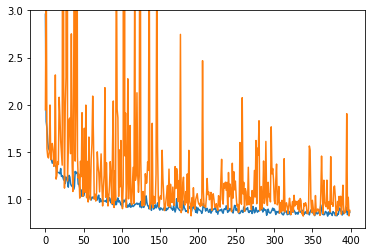

In [96]:
plt.plot(train_loss_his)
plt.plot(valid_loss_his)
plt.ylim(0.7,3)

In [92]:
best_model.eval()
prediction = []

# inference Loop
for i, batch in tqdm(enumerate(test_loader)):
    with torch.no_grad():
      batch = batch.to(device)
      pred = best_model(batch)
      prediction += [pred.data.cpu().numpy()[0]] # model의 예측 값을 list에 저장

1217it [00:04, 281.05it/s]


In [93]:
submission = pd.read_csv("/content/drive/MyDrive/Sample_Submission.csv", index_col=0)
submission.head()

,Predicted
Id,
test_0,0.0
test_1,0.0
test_2,0.0
test_3,0.0
test_4,0.0


In [94]:
submission.loc[:, ["Predicted"]] = prediction

In [95]:
submission.to_csv("/content/drive/MyDrive/Numerical_Analysis.csv")